In [1]:
"""
Notebook Comparativo: Markowitz Clássico vs Regressão Linear vs MLP
====================================================================

Este notebook compara três abordagens de otimização de portfólios:
1. Markowitz Clássico (média histórica)
2. Markowitz com Regressão Linear
3. Markowitz com MLP (Multi-Layer Perceptron)

Gera:
- Previsões de retornos (mu)
- Pesos ótimos dos portfólios
- Métricas financeiras (Sharpe, retorno, volatilidade)
- Gráficos comparativos
- CSVs com resultados
"""

import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuração de estilo (compatibilidade)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Imports principais
from src.data.loader import load_prices, compute_returns
from src.models.lr import predict_mean_returns
from src.optimization.markowitz import solve_markowitz, portfolio_return, portfolio_volatility
from src.optimization.evaluation import (
    evaluate_portfolio,
    calculate_sharpe_ratio,
    calculate_annualized_return,
    calculate_annualized_volatility
)
from src.utils.visualization import (
    plot_efficient_frontier_comparison,
    plot_portfolio_timeseries,
    plot_covariance_heatmap,
    plot_predicted_returns_histogram,
    plot_sharpe_comparison
)
from src.utils.export import (
    save_portfolio_metrics,
    save_portfolio_weights,
    save_predicted_returns,
    save_all_metrics_comparison
)
from src.utils.portfolio_utils import get_optimal_portfolio_max_sharpe
from outputs.charts.markowitz_plot import compare_frontiers

# Configuração de diretórios
OUTPUTS_DIR = Path("../outputs")
CHARTS_DIR = OUTPUTS_DIR / "charts"
MODELS_DIR = OUTPUTS_DIR / "models"
PREDICTIONS_DIR = OUTPUTS_DIR / "predictions"

# Criar diretórios se não existirem
CHARTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

print("  Imports concluídos e diretórios criados") 




  Imports concluídos e diretórios criados


## 1. Configuração dos Parâmetros

In [2]:

# CONFIGURAÇÕES DO EXPERIMENTO


# Ativos do portfólio (ações brasileiras)
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

# Período de análise
start_date = "2010-01-01"
end_date = "2025-01-01"

# Parâmetros dos modelos
window = 24  # Janela de features (lags)
alpha_blend = 0.3  # Blending: 0.0 = sem correção, 1.0 = apenas previsão

# Taxa livre de risco (Selic anual, aproximadamente 15% ao ano em 2025)
RISK_FREE_RATE_ANNUAL = 0.15

# Períodos por ano (mensal = 12)
# NOTA: Estamos usando retornos MENSALAIS, então PERIODS_PER_YEAR = 12
PERIODS_PER_YEAR = 12

# Taxa livre de risco no período mensal (convertida de anual para mensal)
risk_free_rate_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / PERIODS_PER_YEAR) - 1

print(f" Configuração:")
print(f"   - {len(tickers)} ativos")
print(f"   - Período: {start_date} a {end_date}")
print(f"   - Janela: {window} períodos")
print(f"   - Alpha blend: {alpha_blend}")
print(f"   - Taxa livre de risco: {RISK_FREE_RATE_ANNUAL*100:.1f}% a.a. (Selic)")
print(f"   - Taxa livre de risco mensal: {risk_free_rate_period*100:.4f}% a.m.")
print(f"   - Escala: MENSAL (PERIODS_PER_YEAR = {PERIODS_PER_YEAR})")


 Configuração:
   - 9 ativos
   - Período: 2010-01-01 a 2025-01-01
   - Janela: 24 períodos
   - Alpha blend: 0.3
   - Taxa livre de risco: 15.0% a.a. (Selic)
   - Taxa livre de risco mensal: 1.1715% a.m.
   - Escala: MENSAL (PERIODS_PER_YEAR = 12)


## 2. Carregamento e Preparação dos Dados

In [3]:
# Carregar preços históricos
print(" Carregando dados do Yahoo Finance...")
prices = load_prices(tickers, start=start_date, end=end_date)
print(f"  Dados carregados: {prices.shape[0]} dias, {prices.shape[1]} ativos")
print(f"   Período: {prices.index[0].date()} a {prices.index[-1].date()}")

 Carregando dados do Yahoo Finance...


/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed

  Dados carregados: 3722 dias, 9 ativos
   Período: 2010-01-04 a 2024-12-30


In [4]:
# Calcular retornos mensais
returns = compute_returns(prices, freq='monthly')
print(f"  Retornos mensais calculados: {returns.shape[0]} meses")
print(f"\n Estatísticas descritivas dos retornos:")
print(returns.describe().round(4))

  Retornos mensais calculados: 179 meses

 Estatísticas descritivas dos retornos:
Ticker  ABEV3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  GGBR4.SA  ITUB4.SA  PETR4.SA  \
count   179.0000  179.0000  179.0000  179.0000  179.0000  179.0000  179.0000   
mean      0.0092    0.0087    0.0148    0.0077    0.0099    0.0107    0.0159   
std       0.0648    0.1066    0.1103    0.0896    0.1271    0.0827    0.1250   
min      -0.1854   -0.6794   -0.4018   -0.3193   -0.4053   -0.2781   -0.4479   
25%      -0.0288   -0.0566   -0.0420   -0.0480   -0.0642   -0.0394   -0.0677   
50%       0.0041   -0.0016    0.0047    0.0005    0.0000    0.0093    0.0074   
75%       0.0458    0.0729    0.0768    0.0604    0.0741    0.0683    0.0834   
max       0.2037    0.3210    0.4755    0.2691    0.8527    0.2295    0.6167   

Ticker  VALE3.SA  WEGE3.SA  
count   179.0000  179.0000  
mean      0.0100    0.0217  
std       0.1002    0.0814  
min      -0.2778   -0.2213  
25%      -0.0528   -0.0308  
50%      -0.0014    0.0

## 3. Treinamento dos Modelos Preditivos

Agora vamos treinar os modelos de Regressão Linear e MLP para prever os retornos esperados (mu).

## 3.1. Visualização da Matriz de Covariância


In [5]:

# MODELO 1: REGRESSÃO LINEAR

print("Treinando Regressão Linear...")
pred_lr_monthly, split_idx, pure_monthly, cov_monthly = predict_mean_returns(
    returns, 
    window=window, 
    alpha_blend=alpha_blend, 
    model_machine_learning='LinearRegression'
)
print(f"  Regressão Linear concluída")
print(f"   Split treino/teste: {split_idx} meses ({split_idx/len(returns)*100:.1f}% treino)")


# MODELO 2: MLP (Multi-Layer Perceptron)

print("\n Treinando MLP...")
pred_mlp_monthly, _, _, _ = predict_mean_returns(
    returns, 
    window=window, 
    alpha_blend=alpha_blend, 
    model_machine_learning='MLPRegressor'
)
print(f"  MLP concluído")


# MODELO 3: MARKOWITZ CLÁSSICO (média histórica)

print("\n Markowitz Clássico (média histórica)")
print(f"  Usando média histórica do período de treino")

print(f"\n mo das previsões:")
print(f"\n{'Ativo':<12} {'LR (mu)':<12} {'MLP (mu)':<12} {'Histórico (mu)':<15}")
print("-" * 55)
for ticker in returns.columns:
    print(f"{ticker:<12} {pred_lr_monthly[ticker]:>10.6f}  {pred_mlp_monthly[ticker]:>10.6f}  {pure_monthly[ticker]:>13.6f}") 

Treinando Regressão Linear...


Ativo: ABEV3.SA - Retorno Médio Previsto: 0.006835 - Retorno Médio Real: 0.009221.
Ativo: B3SA3.SA - Retorno Médio Previsto: 0.026434 - Retorno Médio Real: 0.008693.
Ativo: BBAS3.SA - Retorno Médio Previsto: 0.011040 - Retorno Médio Real: 0.014830.
Ativo: BBDC4.SA - Retorno Médio Previsto: 0.008371 - Retorno Médio Real: 0.007723.
Ativo: GGBR4.SA - Retorno Médio Previsto: 0.003569 - Retorno Médio Real: 0.009891.
Ativo: ITUB4.SA - Retorno Médio Previsto: 0.009197 - Retorno Médio Real: 0.010707.
Ativo: PETR4.SA - Retorno Médio Previsto: 0.012714 - Retorno Médio Real: 0.015880.
Ativo: VALE3.SA - Retorno Médio Previsto: 0.016962 - Retorno Médio Real: 0.010034.
Ativo: WEGE3.SA - Retorno Médio Previsto: 0.032661 - Retorno Médio Real: 0.021661.
  Regressão Linear concluída
   Split treino/teste: 108 meses (60.3% treino)

 Treinando MLP...
Ativo: ABEV3.SA - Retorno Médio Previsto: 0.017211 - Retorno Médio Real: 0.009221.
Ativo: B3SA3.SA - Retorno Médio Previsto: 0.035501 - Retorno Médio Real: 0

In [ ]:
# GRÁFICO 1: Histograma das Previsões de Retornos

print("\n  Gerando histograma das previsões de retornos...")
plot_predicted_returns_histogram(
    pred_lr_monthly,
    pred_mlp_monthly,
    save_path=str(CHARTS_DIR / "predicted_returns_histogram.png"),
    figsize=(14, 6)
)



📊 Gerando histograma das previsões de retornos...
Gráfico salvo em: ../outputs/charts/predicted_returns_histogram.png


In [ ]:
# GRÁFICO 2: Heatmap da Matriz de Covariância

print("\n  Gerando heatmap da matriz de covariância...")
plot_covariance_heatmap(
    cov_monthly,
    save_path=str(CHARTS_DIR / "covariance_heatmap.png"),
    figsize=(12, 10)
)



📊 Gerando heatmap da matriz de covariância...
Gráfico salvo em: ../outputs/charts/covariance_heatmap.png


## 4. Otimização de Portfólios (Markowitz)

Agora vamos otimizar os portfólios usando os três conjuntos de retornos esperados (mu).

In [8]:

# CONSTRUÇÃO DOS MODELOS PARA COMPARAÇÃO


models = [
    {
        "name": "Markowitz Classico",
        "mean_returns": pure_monthly,
        "cov": cov_monthly,
        "color": "blue",
        "linestyle": "-",
    },
    {
        "name": "Markowitz + Regressao Linear",
        "mean_returns": pred_lr_monthly,
        "cov": cov_monthly,
        "color": "orange",
        "linestyle": "--",
    },
    {
        "name": "Markowitz + MLP",
        "mean_returns": pred_mlp_monthly,
        "cov": cov_monthly,
        "color": "green",
        "linestyle": "-.",
    },
]

print("  Modelos configurados para comparação")

  Modelos configurados para comparação


## 5.1. Visualização das Fronteiras Eficientes


In [ ]:
# GRÁFICO 3: Comparação das Fronteiras Eficientes

print("\n  Gerando gráfico de comparação das fronteiras eficientes...")
plot_efficient_frontier_comparison(
    models,
    save_path=str(CHARTS_DIR / "efficient_frontier_comparison.png"),
    figsize=(12, 8)
)



📊 Gerando gráfico de comparação das fronteiras eficientes...
Gráfico salvo em: ../outputs/charts/efficient_frontier_comparison.png


# Solve Markowitz once

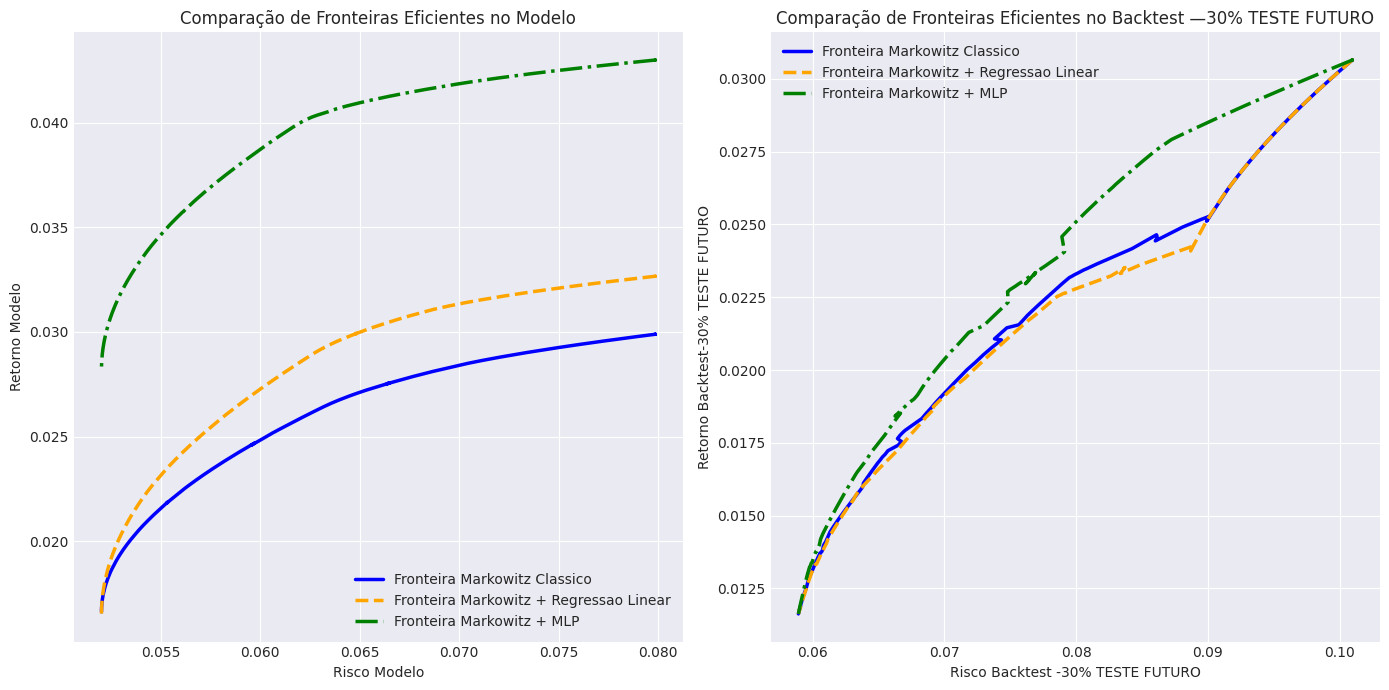

In [10]:
ret_curve, vol_curve, lambdas, w_list = compare_frontiers(models, window=window, returns_monthly=returns, split_idx=split_idx)

## 6. Visualização Temporal dos Portfólios


In [ ]:
# GRÁFICO 4: Comparação Temporal dos Portfólios (usando risco médio)

# Calcular risco médio para usar como target
target_risk_mean = np.mean([np.mean(vol_curve[i]) for i in range(len(vol_curve))])

print(f"\n  Gerando gráfico de comparação temporal dos portfólios...")
print(f"   Target Risk: {target_risk_mean:.4f}")

plot_portfolio_timeseries(
    models,
    returns,
    split_idx,
    target_risk=target_risk_mean,
    lambdas=lambdas,
    w_list=w_list,
    ret_curve=ret_curve,
    vol_curve=vol_curve,
    save_path=str(CHARTS_DIR / "portfolio_timeseries_comparison.png"),
    figsize=(14, 8)
)



📊 Gerando gráfico de comparação temporal dos portfólios...
   Target Risk: 0.0597
Gráfico salvo em: ../outputs/charts/portfolio_timeseries_comparison.png


## 7. Análise de Sensibilidade por Níveis de Risco


In [12]:
from outputs.charts.markowitz_plot import (
    find_lambda_for_risk,
    solve_markowitz,
    portfolio_volatility,
    portfolio_return
)
from src.optimization.markowitz import solve_markowitz, portfolio_return, portfolio_volatility

# from src.data.loader import load_prices, compute_returns
# from src.models.lr import predict_mean_returns
# from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
# from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

def compare_time_series_local(
    models: list,
    target_risk: float = 0.014,
    w_list: list = None,
    lambdas: list = None,
    ret_curve: list = None,
    vol_curve: list = None,
):
    """
    Compara o crescimento acumulado mensal de N modelos.

    Cada item de 'models':
    {
        "name": str,
        "mean_returns": pd.Series,
        "cov": pd.DataFrame,
        "color": str,
        "linestyle": str
    }
    """

    plt.figure(figsize=(14, 8))
    counter = 0
    for model in models:

        name = model["name"]
        mean = model["mean_returns"]
        cov = model["cov"]


        lamb = None
        min_diff = 10e10
        for i, lambd in enumerate(lambdas):
            if np.abs(vol_curve[counter][i] - target_risk) <= min_diff:
                min_diff = np.abs(vol_curve[counter][i] - target_risk)
                lamb = lambd


        index_lamb = lambdas.tolist().index(lamb)
        weights = w_list[counter][index_lamb]


        port = returns[split_idx:].dot(weights)

        print("Lambda {}, Name: {}, Volatility: {:.4f}, Mean Return: {:.4f}".format(lamb, name, port.std(), port.mean()   ))

        # print("Actual mean return: {}".format(portfolio_return(weights, port.mean() )))

        # port = returns[split_idx:].dot(weights)
        # print("Actual return: {}".format(port.mean())) 


        acum = (1 + returns[split_idx:].dot(weights)).cumprod()
        plt.plot(
            acum.index, acum,
            # acum.index, acum,
            label=name,
            linewidth=2,
            color=model["color"],
            linestyle=model["linestyle"],
            # marker='o', markersize=5
        )
        counter += 1

    plt.title("Comparação Temporal dos Portfólios (Backtest). Target Risk: {:.4f}".format(target_risk))
    plt.xlabel("Tempo (Mensal)")
    plt.ylabel("Crescimento Acumulado")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
np.min( [np.min(vol_curve[0]), np.min(vol_curve[1])]  )

np.float64(0.052014263712589666)

In [14]:
min_risk = np.max( [np.min(vol_curve[0]), np.min(vol_curve[1])]  )
max_risk = np.min( [np.max(vol_curve[0]), np.max(vol_curve[1])]  )

Lambda 1.0, Name: Markowitz Classico, Volatility: 0.0589, Mean Return: 0.0116
Lambda 1.0, Name: Markowitz + Regressao Linear, Volatility: 0.0589, Mean Return: 0.0116


Lambda 1.0, Name: Markowitz + MLP, Volatility: 0.0589, Mean Return: 0.0116


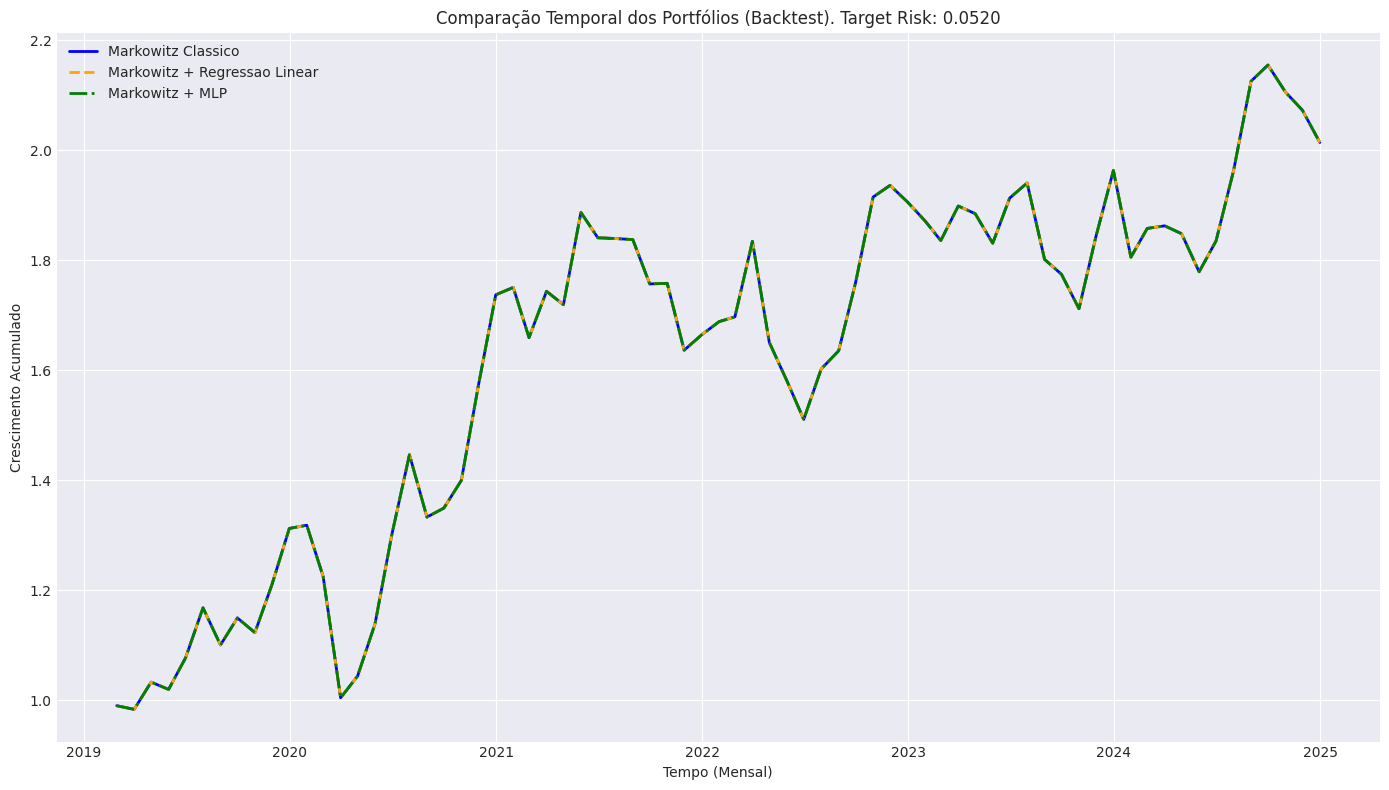

Lambda 0.365, Name: Markowitz Classico, Volatility: 0.0730, Mean Return: 0.0205
Lambda 0.41500000000000004, Name: Markowitz + Regressao Linear, Volatility: 0.0731, Mean Return: 0.0204
Lambda 0.41500000000000004, Name: Markowitz + MLP, Volatility: 0.0705, Mean Return: 0.0206


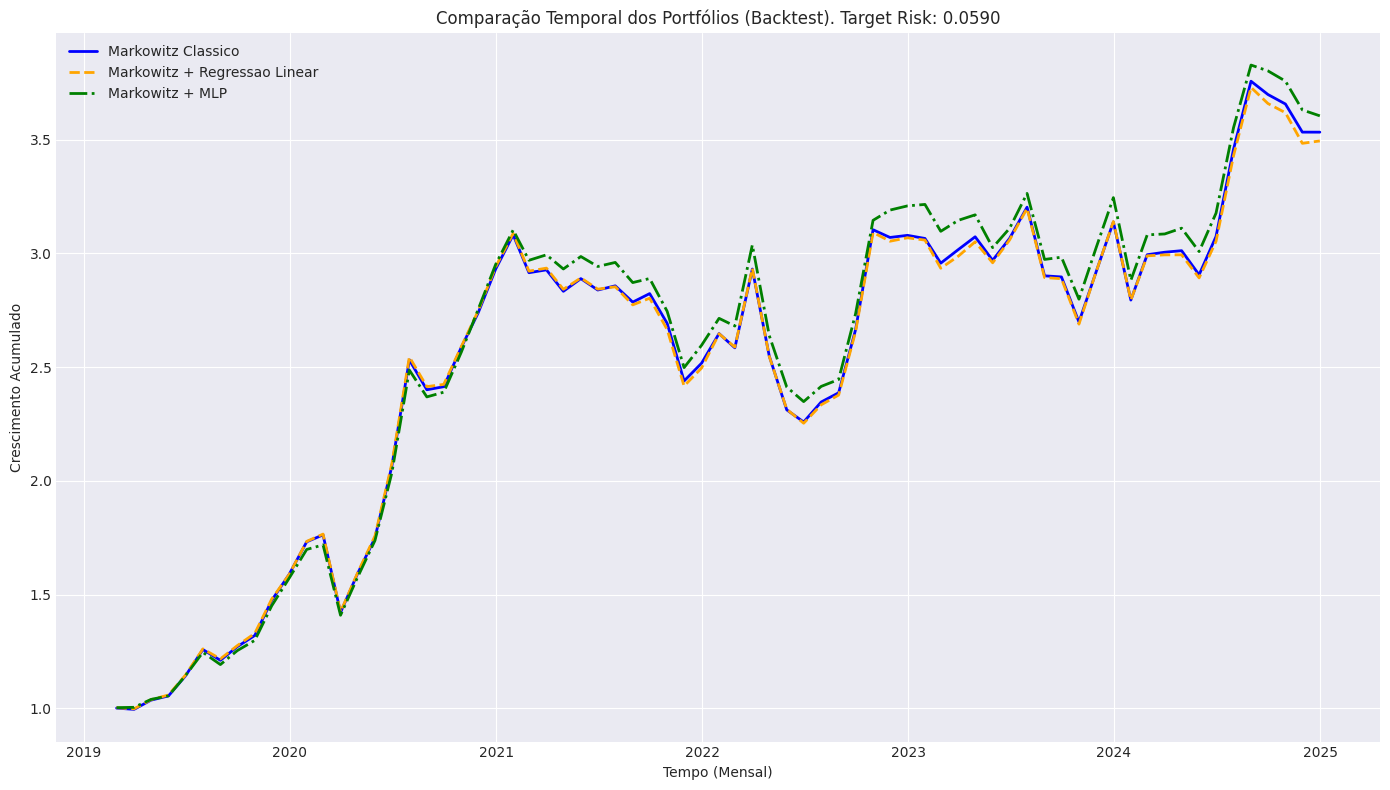

Lambda 0.20500000000000002, Name: Markowitz Classico, Volatility: 0.0860, Mean Return: 0.0244
Lambda 0.24, Name: Markowitz + Regressao Linear, Volatility: 0.0857, Mean Return: 0.0237
Lambda 0.17, Name: Markowitz + MLP, Volatility: 0.0821, Mean Return: 0.0260


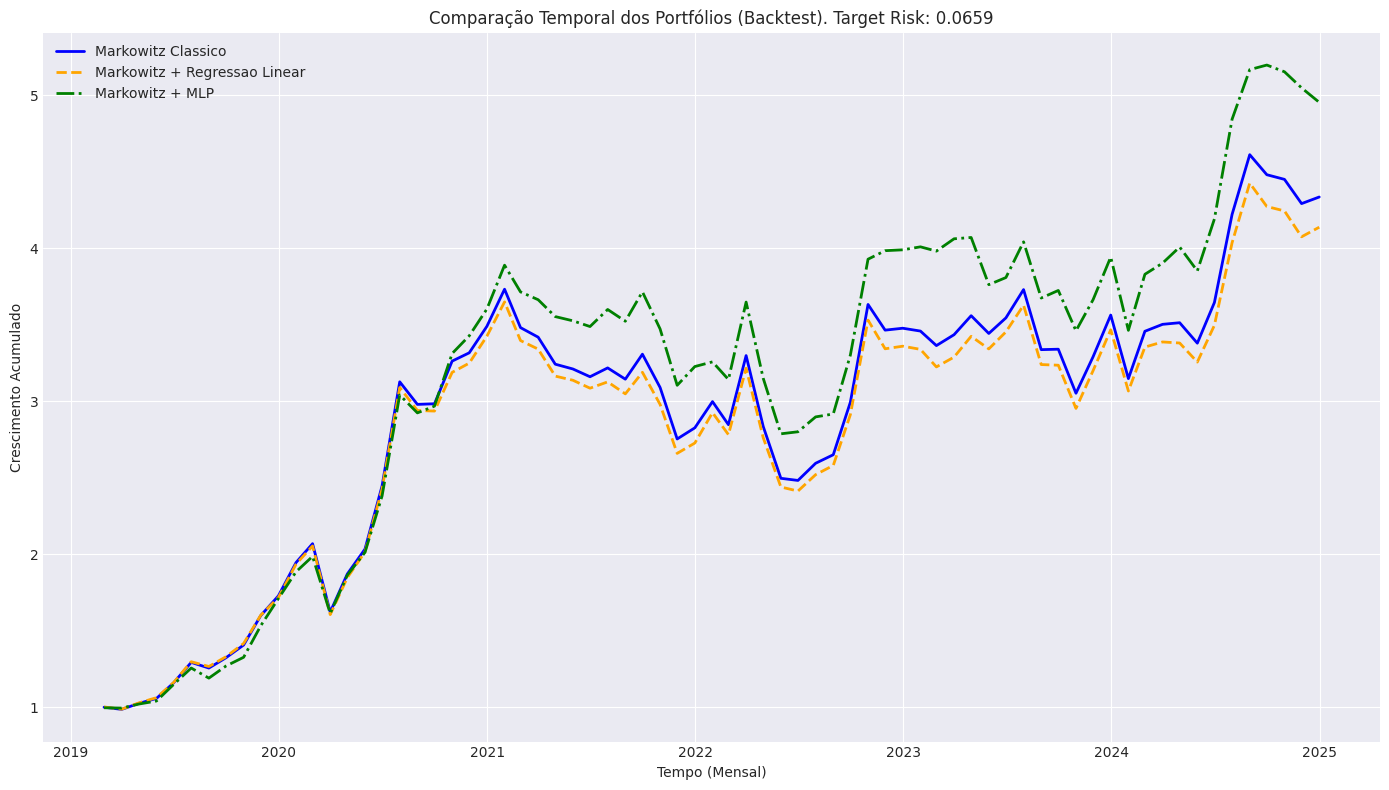

Lambda 0.14, Name: Markowitz Classico, Volatility: 0.0937, Mean Return: 0.0274
Lambda 0.125, Name: Markowitz + Regressao Linear, Volatility: 0.0941, Mean Return: 0.0276
Lambda 0.11, Name: Markowitz + MLP, Volatility: 0.0912, Mean Return: 0.0288


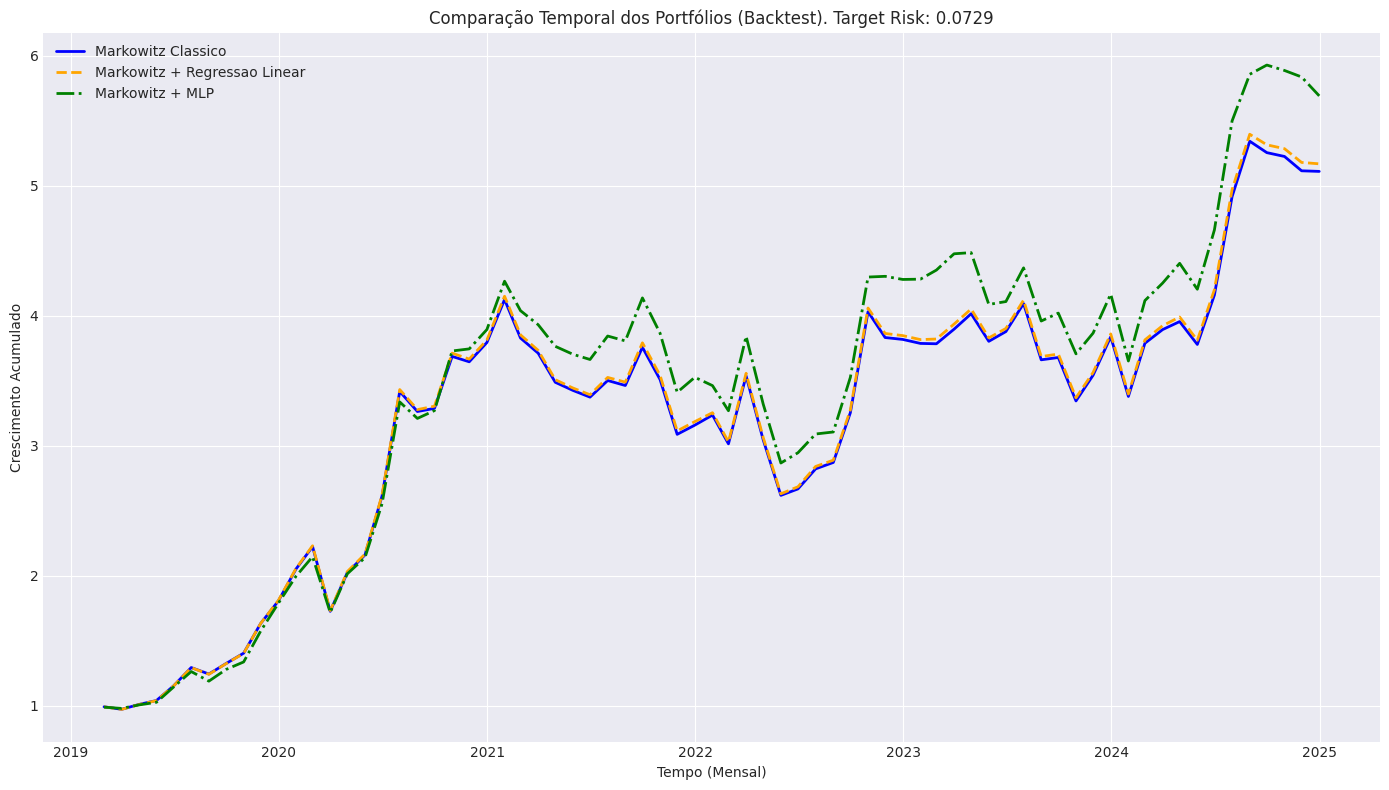

Lambda 0.08, Name: Markowitz Classico, Volatility: 0.1010, Mean Return: 0.0306
Lambda 0.095, Name: Markowitz + Regressao Linear, Volatility: 0.1010, Mean Return: 0.0306
Lambda 0.085, Name: Markowitz + MLP, Volatility: 0.1010, Mean Return: 0.0306


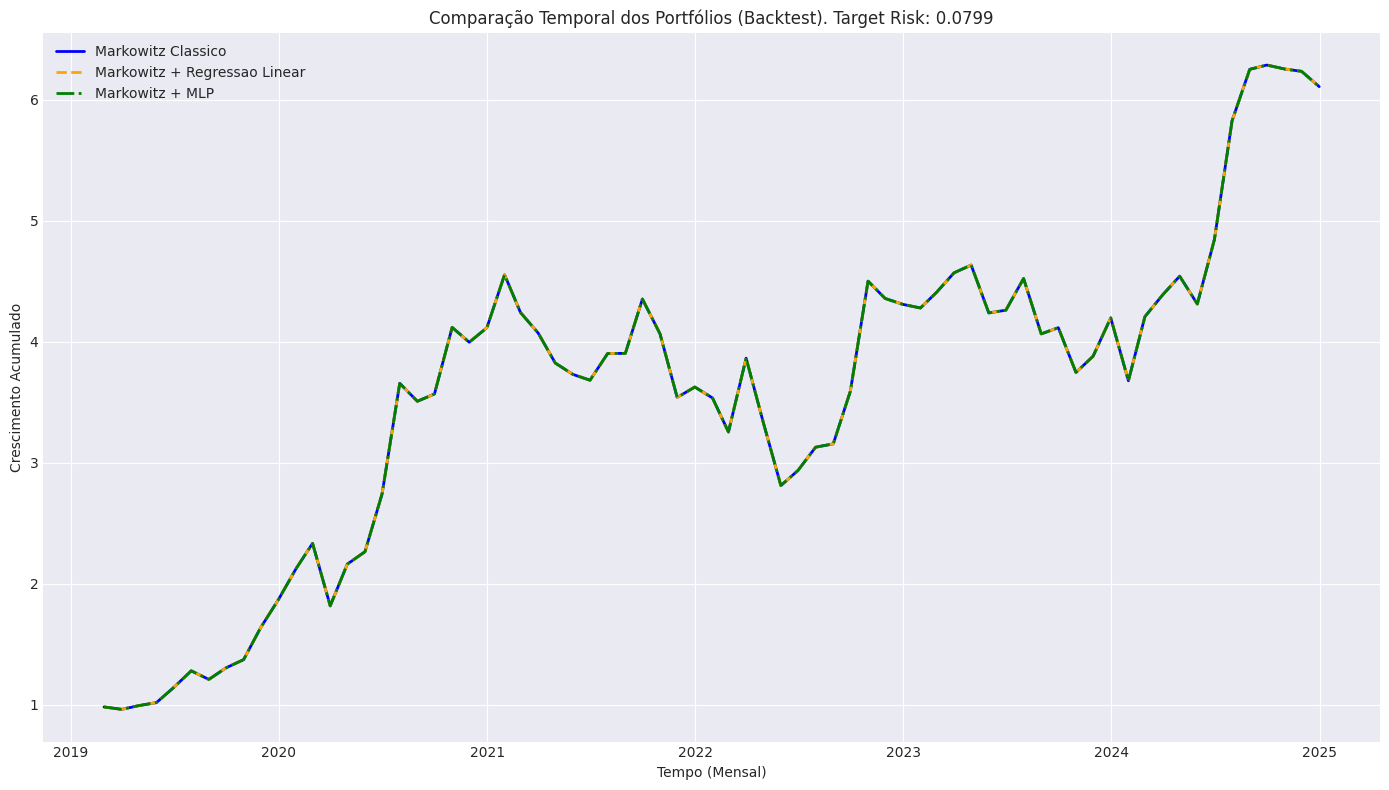

In [15]:
for target_risk in np.linspace(min_risk, max_risk, 5): 
    compare_time_series_local(models, target_risk=target_risk, w_list=w_list, lambdas=lambdas, ret_curve=ret_curve, vol_curve=vol_curve)

## 8. Cálculo de Métricas dos Portfólios

Agora vamos calcular as métricas financeiras (Sharpe, retorno anualizado, volatilidade) para cada modelo.


In [16]:

# CÁLCULO DE MÉTRICAS PARA CADA MODELO

# NOTA: Usamos otimização de Máximo Sharpe Ratio para garantir que as diferenças
# nas previsões de mu sejam refletidas nos pesos. Alternativamente, poderíamos usar
# lambda fixo (ex: 0.5) ou target_risk, mas máximo Sharpe é mais apropriado para
# comparação justa entre modelos.
# 
# risk_free_rate_period já está definido na célula 2 (configurações)

test_returns = returns.iloc[split_idx:]
all_metrics = []

print(" Calculando métricas dos portfólios usando Máximo Sharpe Ratio...")
print(f"   Taxa livre de risco mensal: {risk_free_rate_period:.4f} ({RISK_FREE_RATE_ANNUAL*100:.1f}% a.a.)")

for i, model in enumerate(models):
    name = model["name"]
    mean_returns = model["mean_returns"]
    cov_matrix = model["cov"]
    
    # Otimizar para máximo Sharpe Ratio
    # Isso garante que as diferenças em mu sejam refletidas nos pesos
    weights = get_optimal_portfolio_max_sharpe(
        mean_returns,
        cov_matrix,
        risk_free_rate=risk_free_rate_period
    )
    
    # Calcular retornos do portfólio no período de teste
    portfolio_ret = test_returns.dot(weights)
    
    # Avaliar portfólio
    metrics = evaluate_portfolio(
        portfolio_ret,
        risk_free_rate_annual=RISK_FREE_RATE_ANNUAL,
        periods_per_year=PERIODS_PER_YEAR,
        model_name=name
    )
    
    all_metrics.append(metrics)
    
    print(f"\n OK - {name}:")
    print(f"   Sharpe: {metrics['Sharpe']:.4f}")
    print(f"   Retorno Anualizado: {metrics['Annualized_Return']:.2%}")
    print(f"   Volatilidade Anualizada: {metrics['Annualized_Volatility']:.2%}")
    print(f"   Retorno Acumulado: {metrics['Cumulative_Return']:.2f}x")
    print(f"   Pesos: {dict(zip(tickers, weights.round(4)))}")

# Criar DataFrame com todas as métricas
metrics_df = pd.DataFrame(all_metrics)
print(f"\n Tabela de Métricas:")
print(metrics_df.to_string(index=False))


 Calculando métricas dos portfólios usando Máximo Sharpe Ratio...
   Taxa livre de risco mensal: 0.0117 (15.0% a.a.)

 OK - Markowitz Classico:
   Sharpe: 0.5247
   Retorno Anualizado: 34.83%
   Volatilidade Anualizada: 30.88%
   Retorno Acumulado: 4.50x
   Pesos: {'PETR4.SA': np.float64(0.0), 'VALE3.SA': np.float64(0.2324), 'ITUB4.SA': np.float64(0.0), 'BBDC4.SA': np.float64(0.0), 'BBAS3.SA': np.float64(0.0), 'ABEV3.SA': np.float64(0.0), 'WEGE3.SA': np.float64(0.0), 'B3SA3.SA': np.float64(0.014), 'GGBR4.SA': np.float64(0.7536)}

 OK - Markowitz + Regressao Linear:
   Sharpe: 0.4901
   Retorno Anualizado: 33.15%
   Volatilidade Anualizada: 30.45%
   Retorno Acumulado: 4.20x
   Pesos: {'PETR4.SA': np.float64(0.0), 'VALE3.SA': np.float64(0.2811), 'ITUB4.SA': np.float64(0.0), 'BBDC4.SA': np.float64(0.0), 'BBAS3.SA': np.float64(0.0), 'ABEV3.SA': np.float64(0.0), 'WEGE3.SA': np.float64(0.0), 'B3SA3.SA': np.float64(0.013), 'GGBR4.SA': np.float64(0.7059)}

 OK - Markowitz + MLP:
   Sharpe: 0.

In [17]:

# GRÁFICO 5: Comparação de Sharpe Ratio

print("\n Gerando gráfico de comparação de Sharpe...")
plot_sharpe_comparison(
    metrics_df,
    save_path=str(CHARTS_DIR / "sharpe_comparison.png"),
    figsize=(10, 6)
)



 Gerando gráfico de comparação de Sharpe...


Gráfico salvo em: ../outputs/charts/sharpe_comparison.png


In [18]:
## 9. Exportação de Resultados em CSV


In [19]:

# SALVAR MÉTRICAS DOS PORTFÓLIOS

print(" Salvando métricas dos portfólios...")
save_all_metrics_comparison(
    all_metrics,
    save_path=str(MODELS_DIR / "all_models_metrics.csv")
)

# Salvar métricas individuais
for i, model in enumerate(models):
    save_portfolio_metrics(
        all_metrics[i],
        save_path=str(MODELS_DIR / f"{model['name'].lower().replace(' ', '_')}_metrics.csv")
    )


 Salvando métricas dos portfólios...
Comparação de métricas salva em: ../outputs/models/all_models_metrics.csv
Métricas salvas em: ../outputs/models/markowitz_classico_metrics.csv
Métricas salvas em: ../outputs/models/markowitz_+_regressao_linear_metrics.csv
Métricas salvas em: ../outputs/models/markowitz_+_mlp_metrics.csv


In [20]:

# SALVAR PESOS DOS PORTFÓLIOS (Máximo Sharpe)

print(" Salvando pesos dos portfólios (otimizados para máximo Sharpe)...")

for i, model in enumerate(models):
    mean_returns = model["mean_returns"]
    cov_matrix = model["cov"]
    
    # Usar mesma otimização de máximo Sharpe para consistência
    weights = get_optimal_portfolio_max_sharpe(
        mean_returns,
        cov_matrix,
        risk_free_rate=risk_free_rate_period
    )
    
    save_portfolio_weights(
        weights,
        tickers,
        model["name"],
        save_path=str(MODELS_DIR / f"{model['name'].lower().replace(' ', '_')}_weights.csv")
    )

 Salvando pesos dos portfólios (otimizados para máximo Sharpe)...


Pesos salvos em: ../outputs/models/markowitz_classico_weights.csv
Pesos salvos em: ../outputs/models/markowitz_+_regressao_linear_weights.csv
Pesos salvos em: ../outputs/models/markowitz_+_mlp_weights.csv


In [ ]:

# SALVAR PREVISÕES DE RETORNOS (mu)

print(" Salvando previsões de retornos...")

save_predicted_returns(
    pure_monthly,
    "Markowitz_Classico",
    save_path=str(PREDICTIONS_DIR / "markowitz_classico_predictions.csv")
)

save_predicted_returns(
    pred_lr_monthly,
    "Regressao_Linear",
    save_path=str(PREDICTIONS_DIR / "linear_regression_predictions.csv")
)

save_predicted_returns(
    pred_mlp_monthly,
    "MLP",
    save_path=str(PREDICTIONS_DIR / "mlp_predictions.csv")
)

print("\n  Todos os resultados foram salvos!")

 Salvando previsões de retornos...
Previsões salvas em: ../outputs/predictions/markowitz_classico_predictions.csv
Previsões salvas em: ../outputs/predictions/linear_regression_predictions.csv
Previsões salvas em: ../outputs/predictions/mlp_predictions.csv

  Todos os resultados foram salvos!


In [22]:

# TABELA 1: Métricas dos Portfólios

print(" TABELA 1: Métricas dos Portfólios")
print("=" * 80)

portfolio_metrics_table = metrics_df[[
    'Model', 
    'Sharpe', 
    'Annualized_Return', 
    'Annualized_Volatility', 
    'Cumulative_Return'
]].copy()

portfolio_metrics_table['Annualized_Return'] = portfolio_metrics_table['Annualized_Return'].apply(lambda x: f"{x:.2%}")
portfolio_metrics_table['Annualized_Volatility'] = portfolio_metrics_table['Annualized_Volatility'].apply(lambda x: f"{x:.2%}")
portfolio_metrics_table['Sharpe'] = portfolio_metrics_table['Sharpe'].apply(lambda x: f"{x:.4f}")
portfolio_metrics_table['Cumulative_Return'] = portfolio_metrics_table['Cumulative_Return'].apply(lambda x: f"{x:.2f}x")

print(portfolio_metrics_table.to_string(index=False))

# Salvar tabela
portfolio_metrics_table.to_csv(MODELS_DIR / "portfolio_metrics_table.csv", index=False)


 TABELA 1: Métricas dos Portfólios


                       Model Sharpe Annualized_Return Annualized_Volatility Cumulative_Return
          Markowitz Classico 0.5247            34.83%                30.88%             4.50x
Markowitz + Regressao Linear 0.4901            33.15%                30.45%             4.20x
             Markowitz + MLP 0.5154            31.41%                26.34%             4.15x


In [23]:

# TABELA 2: Comparação de mu (Retornos Esperados) por Modelo

print("\n TABELA 2: Retornos Esperados (mu) por Modelo")
print("=" * 80)

mu_comparison = pd.DataFrame({
    'Ticker': tickers,
    'Markowitz_Classico': pure_monthly.values,
    'Regressao_Linear': pred_lr_monthly.values,
    'MLP': pred_mlp_monthly.values
})

mu_comparison_display = mu_comparison.copy()
for col in ['Markowitz_Classico', 'Regressao_Linear', 'MLP']:
    mu_comparison_display[col] = mu_comparison_display[col].apply(lambda x: f"{x:.6f}")

print(mu_comparison_display.to_string(index=False))

# Salvar tabela
mu_comparison.to_csv(PREDICTIONS_DIR / "mu_comparison_table.csv", index=False)



 TABELA 2: Retornos Esperados (mu) por Modelo
  Ticker Markowitz_Classico Regressao_Linear      MLP
PETR4.SA           0.008763         0.006835 0.017211
VALE3.SA           0.022914         0.026434 0.035501
ITUB4.SA           0.015297         0.011040 0.020500
BBDC4.SA           0.013160         0.008371 0.021538
BBAS3.SA           0.013956         0.003569 0.020462
ABEV3.SA           0.012935         0.009197 0.021267
WEGE3.SA           0.012944         0.012714 0.020846
B3SA3.SA           0.015533         0.016962 0.035549
GGBR4.SA           0.029889         0.032661 0.042992


In [24]:

# TABELA 3: Pesos dos Portfólios por Modelo

print("\n TABELA 3: Pesos dos Portfólios (Target Risk)")
print("=" * 80)

weights_comparison = pd.DataFrame({'Ticker': tickers})

for i, model in enumerate(models):
    # Encontrar melhor lambda
    min_diff = float('inf')
    best_idx = 0
    for j, vol in enumerate(vol_curve[i]):
        diff = abs(vol - target_risk)
        if diff < min_diff:
            min_diff = diff
            best_idx = j
    
    weights = w_list[i][best_idx]
    weights_comparison[model['name']] = weights

weights_comparison_display = weights_comparison.copy()
for col in weights_comparison.columns[1:]:
    weights_comparison_display[col] = weights_comparison_display[col].apply(lambda x: f"{x:.4f}")

print(weights_comparison_display.to_string(index=False))

# Salvar tabela
weights_comparison.to_csv(MODELS_DIR / "weights_comparison_table.csv", index=False)



 TABELA 3: Pesos dos Portfólios (Target Risk)
  Ticker Markowitz Classico Markowitz + Regressao Linear Markowitz + MLP
PETR4.SA             0.0000                       0.0000          0.0000
VALE3.SA             0.0000                       0.0000          0.0000
ITUB4.SA             0.0000                       0.0000          0.0000
BBDC4.SA             0.0000                       0.0000          0.0000
BBAS3.SA             0.0000                       0.0000          0.0000
ABEV3.SA             0.0000                       0.0000          0.0000
WEGE3.SA             0.0000                       0.0000          0.0000
B3SA3.SA             0.0000                       0.0000          0.0000
GGBR4.SA             1.0000                       1.0000          1.0000
